In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def test_decay_single_season(db_path, league, season, decay_rates, 
                           test_points=[90, 120, 150, 210, -35],
                           trace=1000, tune=500):
   """Test decay rates at multiple points for a single season"""
   
   from src.data_utils import load_and_process_data
   from src.model import build_and_sample_model
   from scipy.stats import poisson
   
   # Get season dates first
   df_sample, _, _ = load_and_process_data(
       db_path=db_path, league=league, season=season,
       decay_rate=0.001, max_goals=9,
       goals_weight=0.2, xg_weight=0.5, psxg_weight=0.3
   )
   
   if not pd.api.types.is_datetime64_any_dtype(df_sample['match_date']):
       df_sample['match_date'] = pd.to_datetime(df_sample['match_date'])
   
   actual_df = df_sample[df_sample['is_actual'] == True]
   season_start = actual_df['match_date'].min()
   season_end = actual_df['match_date'].max()
   
   season_results = []
   
   for decay_rate in decay_rates:
       period_scores = []
       
       for test_point in test_points:
           # Calculate test date
           if test_point < 0:
               test_date = season_end + pd.Timedelta(days=test_point)
           else:
               test_date = season_start + pd.Timedelta(days=test_point)
           
           # Skip invalid dates
           if test_date < season_start + pd.Timedelta(days=60) or \
              test_date > season_end - pd.Timedelta(days=20):
               continue
           
           try:
               # Load data with this decay rate
               df, team_mapping, n_teams = load_and_process_data(
                   db_path=db_path, league=league, season=season,
                   decay_rate=decay_rate, max_goals=9,
                   goals_weight=0.2, xg_weight=0.5, psxg_weight=0.3
               )
               
               if not pd.api.types.is_datetime64_any_dtype(df['match_date']):
                   df['match_date'] = pd.to_datetime(df['match_date'])
               
               # Split data
               train_df = df[df['match_date'] <= test_date].copy()
               val_df = df[(df['match_date'] > test_date) & 
                          (df['match_date'] <= test_date + pd.Timedelta(days=35))].copy()
               val_df = val_df[val_df['is_actual'] == True]
               
               if len(train_df[train_df['is_actual']==True]) < 50 or len(val_df) < 10:
                   continue
               
               # Train model
               model, trace_result = build_and_sample_model(
                   train_df, n_teams, trace=trace, tune=tune
               )
               
               # Extract parameters and predict
               home_adv = trace_result.posterior['home_adv'].mean().values
               baseline = trace_result.posterior['baseline'].mean().values
               att_str = trace_result.posterior['att_str'].mean(dim=['chain', 'draw']).values
               def_str = trace_result.posterior['def_str'].mean(dim=['chain', 'draw']).values
               
               # Evaluate
               val_predictions = []
               for _, match in val_df.iterrows():
                   home_mu = np.exp(baseline + att_str[match['home_idx']] + 
                                   def_str[match['away_idx']] + home_adv)
                   away_mu = np.exp(baseline + att_str[match['away_idx']] + 
                                   def_str[match['home_idx']])
                   val_predictions.append({
                       'home_mu': home_mu, 'away_mu': away_mu,
                       'home_actual': match['home_goals'],
                       'away_actual': match['away_goals']
                   })
               
               pred_df = pd.DataFrame(val_predictions)
               home_ll = poisson.logpmf(pred_df['home_actual'], pred_df['home_mu']).mean()
               away_ll = poisson.logpmf(pred_df['away_actual'], pred_df['away_mu']).mean()
               total_ll = home_ll + away_ll
               
               period_scores.append(total_ll)
               
           except Exception as e:
               continue
       
       if period_scores:
           season_results.append({
               'decay_rate': decay_rate,
               'avg_ll': np.mean(period_scores),
               'std_ll': np.std(period_scores),
               'n_periods': len(period_scores)
           })
   
   return season_results

In [2]:
def run_multi_season_test():
   db_path = r'C:\Users\Owner\dev\algobetting\infra\data\db\fotmob.db'
   league = 'Premier_League'
   
   # Test multiple seasons
   seasons = ['2022-2023', '2023-2024', '2021-2022', '2024-2025']
   decay_rates = [0.0001, 0.0005, 0.001, 0.002, 0.0035, 0.005, 0.01]
   
   all_results = []
   
   for season in seasons:
       print(f"\n{'='*70}")
       print(f"Testing {league} {season}")
       print('='*70)
       
       season_results = test_decay_single_season(
           db_path, league, season, decay_rates,
           test_points=[90, 120, 150, 210, -35],  # Test at 3,4,5,7 months and end
           trace=500, tune=250  # Smaller for speed
       )
       
       # Add season info to results
       for result in season_results:
           result['season'] = season
           result['league'] = league
           all_results.append(result)
       
       # Print season summary
       if season_results:
           season_df = pd.DataFrame(season_results)
           best_idx = season_df['avg_ll'].idxmax()
           best = season_df.loc[best_idx]
           
           print(f"\n{season} Results:")
           print("Decay Rate | Avg LL    | Std LL")
           print("-" * 35)
           for _, row in season_df.iterrows():
               marker = " *" if row['decay_rate'] == best['decay_rate'] else ""
               print(f"{row['decay_rate']:.4f}     | {row['avg_ll']:+.4f} | {row['std_ll']:.4f}{marker}")
           
           print(f"\nBest for {season}: {best['decay_rate']:.4f} (LL={best['avg_ll']:.4f})")
   
   # Overall analysis
   results_df = pd.DataFrame(all_results)
   
   # Find overall best
   grouped = results_df.groupby('decay_rate').agg({
       'avg_ll': ['mean', 'std'],
       'season': 'count'
   }).reset_index()
   grouped.columns = ['decay_rate', 'overall_avg_ll', 'overall_std_ll', 'n_seasons']
   
   print("\n" + "="*70)
   print("OVERALL RESULTS ACROSS ALL SEASONS")
   print("="*70)
   print("\nDecay Rate | Overall Avg LL | Consistency (Std)")
   print("-" * 50)
   
   for _, row in grouped.iterrows():
       print(f"{row['decay_rate']:.4f}     | {row['overall_avg_ll']:+.4f}      | {row['overall_std_ll']:.4f}")
   
   best_overall_idx = grouped['overall_avg_ll'].idxmax()
   best_overall = grouped.loc[best_overall_idx]
   
   print("\n" + "="*70)
   print(f"RECOMMENDED DECAY RATE: {best_overall['decay_rate']:.4f}")
   print(f"Average LL across seasons: {best_overall['overall_avg_ll']:.4f}")
   print(f"Consistency (std): {best_overall['overall_std_ll']:.4f}")
   print("="*70)
   
   return results_df, grouped


Testing Premier_League 2022-2023


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(



2022-2023 Results:
Decay Rate | Avg LL    | Std LL
-----------------------------------
0.0001     | -3.0270 | 0.2321
0.0005     | -3.0261 | 0.2309
0.0010     | -3.0246 | 0.2291
0.0020     | -3.0254 | 0.2293
0.0035     | -3.0240 | 0.2294 *
0.0050     | -3.0244 | 0.2268
0.0100     | -3.0445 | 0.2225

Best for 2022-2023: 0.0035 (LL=-3.0240)

Testing Premier_League 2023-2024
  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(



2023-2024 Results:
Decay Rate | Avg LL    | Std LL
-----------------------------------
0.0001     | -3.2008 | 0.1783
0.0005     | -3.1991 | 0.1787
0.0010     | -3.1993 | 0.1804
0.0020     | -3.1962 | 0.1808
0.0035     | -3.1960 | 0.1851 *
0.0050     | -3.1968 | 0.1892
0.0100     | -3.2110 | 0.2100

Best for 2023-2024: 0.0035 (LL=-3.1960)

Testing Premier_League 2021-2022
  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(



2021-2022 Results:
Decay Rate | Avg LL    | Std LL
-----------------------------------
0.0001     | -2.9321 | 0.0935
0.0005     | -2.9310 | 0.0932
0.0010     | -2.9307 | 0.0929
0.0020     | -2.9303 | 0.0942 *
0.0035     | -2.9347 | 0.0959
0.0050     | -2.9385 | 0.1009
0.0100     | -2.9703 | 0.1297

Best for 2021-2022: 0.0020 (LL=-2.9303)

Testing Premier_League 2024-2025
  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  → Using default priors (no previous season data)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(



2024-2025 Results:
Decay Rate | Avg LL    | Std LL
-----------------------------------
0.0001     | -3.0186 | 0.1259 *
0.0005     | -3.0187 | 0.1262
0.0010     | -3.0196 | 0.1277
0.0020     | -3.0208 | 0.1301
0.0035     | -3.0237 | 0.1356
0.0050     | -3.0300 | 0.1441
0.0100     | -3.0709 | 0.1804

Best for 2024-2025: 0.0001 (LL=-3.0186)

OVERALL RESULTS ACROSS ALL SEASONS

Decay Rate | Overall Avg LL | Consistency (Std)
--------------------------------------------------
0.0001     | -3.0446      | 0.1126
0.0005     | -3.0437      | 0.1122
0.0010     | -3.0436      | 0.1124
0.0020     | -3.0432      | 0.1110
0.0035     | -3.0446      | 0.1093
0.0050     | -3.0474      | 0.1080
0.0100     | -3.0742      | 0.1007

RECOMMENDED DECAY RATE: 0.0020
Average LL across seasons: -3.0432
Consistency (std): 0.1110


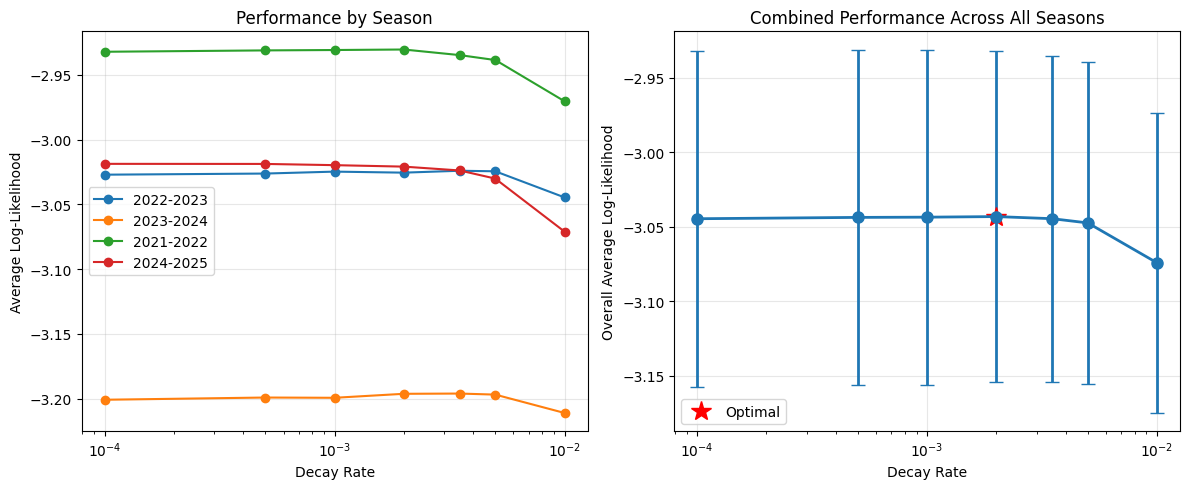

In [3]:
if __name__ == "__main__":
   results_df, summary_df = run_multi_season_test()
   
   # Simple visualization
   import matplotlib.pyplot as plt
   
   fig, axes = plt.subplots(1, 2, figsize=(12, 5))
   
   # Plot 1: Average LL by decay rate for each season
   ax1 = axes[0]
   for season in results_df['season'].unique():
       season_data = results_df[results_df['season'] == season]
       ax1.plot(season_data['decay_rate'], season_data['avg_ll'], 
               'o-', label=season, markersize=6)
   ax1.set_xlabel('Decay Rate')
   ax1.set_ylabel('Average Log-Likelihood')
   ax1.set_title('Performance by Season')
   ax1.set_xscale('log')
   ax1.legend()
   ax1.grid(True, alpha=0.3)
   
   # Plot 2: Overall average with error bars
   ax2 = axes[1]
   ax2.errorbar(summary_df['decay_rate'], 
                summary_df['overall_avg_ll'],
                yerr=summary_df['overall_std_ll'],
                marker='o', markersize=8, linewidth=2, capsize=5)
   best_idx = summary_df['overall_avg_ll'].idxmax()
   ax2.plot(summary_df.loc[best_idx, 'decay_rate'],
            summary_df.loc[best_idx, 'overall_avg_ll'],
            'r*', markersize=15, label='Optimal')
   ax2.set_xlabel('Decay Rate')
   ax2.set_ylabel('Overall Average Log-Likelihood')
   ax2.set_title('Combined Performance Across All Seasons')
   ax2.set_xscale('log')
   ax2.legend()
   ax2.grid(True, alpha=0.3)
   
   plt.tight_layout()
   plt.show()